In [1]:
import pandas as pd
import numpy as np
import pathlib
# import imblearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, auc

In [2]:
BASE_DIR = pathlib.Path().resolve().parent
DATASET_DIR = BASE_DIR / "input"
DATASET_DIR.mkdir(exist_ok=True, parents=True)
TRAIN_PATH = DATASET_DIR / 'train-dataset' / "train.csv"
TEST_PATH = DATASET_DIR / 'test-dataset' / "test.csv"
SUBMISSION_PATH = DATASET_DIR / 'submission-dataset' / "submission.csv"

In [3]:
df = pd.read_csv(TRAIN_PATH)
df.shape

(381109, 12)

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Exploratory Data Analysis

<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

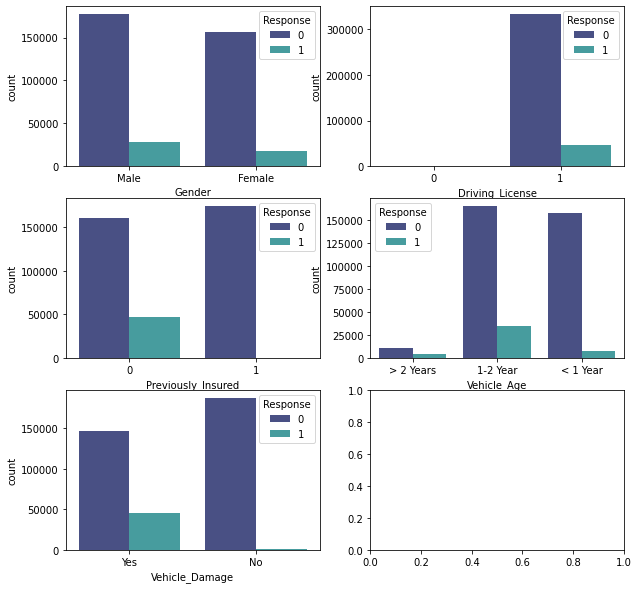

In [7]:
fig , axes = plt.subplots(3, 2, figsize = (10, 10))

sns.countplot(ax = axes[0, 0], x='Gender', hue='Response', data=df, palette='mako')
sns.countplot(ax = axes[0, 1], x='Driving_License', hue='Response', data=df, palette='mako')
sns.countplot(ax = axes[1, 0], x='Previously_Insured', hue='Response', data=df, palette='mako')
sns.countplot(ax = axes[1, 1], x='Vehicle_Age', hue='Response', data=df, palette='mako')
sns.countplot(ax = axes[2, 0], x='Vehicle_Damage', hue='Response', data=df, palette='mako')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Response', ylabel='Count'>

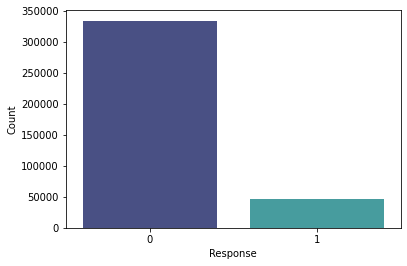

In [8]:
Response = df.loc[:, 'Response'].value_counts().rename('Count')
plt.xlabel('Response')
plt.ylabel('Count')
sns.barplot(Response.index, Response.values, palette='mako')

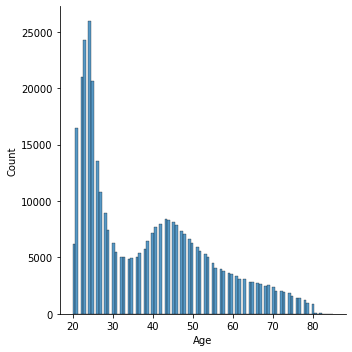

In [9]:
sns.displot(df['Age'])

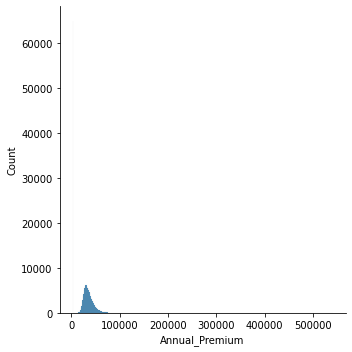

In [10]:
sns.displot(df.Annual_Premium)

## Data Preprocessing

In [11]:
from typing import List

In [12]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('Vehicle_Age')
cat_cols

['Gender', 'Vehicle_Damage']

In [17]:
def data_prep(df: pd.DataFrame, object_cols: List[str]) ->pd.DataFrame:
    df = df.drop(['id', 'Policy_Sales_Channel', 'Vintage', 'Region_Code'], axis=1)
    for col in object_cols:
        df = pd.get_dummies(df, columns=[col], prefix=col)
    df['Age'] = pd.cut(df['Age'], bins=[0, 29, 35, 50, 100])
    df['Age'] = df.Age.cat.codes
    df['Annual_Premium'] = pd.cut(df.Annual_Premium, bins=[0, 35000, 40000, 45000, 50000, np.inf])
    df['Annual_Premium'] = df['Annual_Premium'].cat.codes
    df['Vehicle_Age'] = df.Vehicle_Age.map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 3})
    return df

df1 = data_prep(df, object_cols=cat_cols)

In [18]:
df1.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Annual_Premium,Response,Gender_Female,Gender_Male,Vehicle_Damage_No,Vehicle_Damage_Yes
0,2,1,0,3,2,1,0,1,0,1
1,3,1,0,1,0,0,0,1,1,0
2,2,1,0,3,1,1,0,1,0,1
3,0,1,1,0,0,0,0,1,1,0
4,0,1,1,0,0,0,1,0,1,0


In [16]:
# Exporting treated data
df1.to_csv("../input/modified_df.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df1.drop("Response", axis=1)
y = df1.Response

X.shape, y.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

## Handle Imbalance Dataset

In [ ]:
# pip install -U imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
RUS = RandomUnderSampler(sampling_strategy=0.5, random_state=3)
X_train, Y_train = RUS.fit_resample(X, y)

X_train.shape, Y_train.shape

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size=0.3, random_state=42)
# X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

## Cross Sell Prediction - Model training and prediction

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
def performance_met(model, X_train, Y_train, X_test, Y_test) ->None:
    acc_train=accuracy_score(Y_train, model.predict(X_train))

    f1_train=f1_score(Y_train, model.predict(X_train))

    acc_test=accuracy_score(Y_test, model.predict(X_test))

    f1_test=f1_score(Y_test, model.predict(X_test))

    print("train score: accuracy:{} f1:{}".format(acc_train,f1_train))

    print("test score: accuracy:{} f1:{}".format(acc_test,f1_test))

## 1. Model : Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(X_train,Y_train) 
performance_met(model,X_train,Y_train,X_test,Y_test)


## 2. Model : Decision Tree Classifier

In [ ]:
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, Y_train)
performance_met(model_DT, X_train, Y_train, X_test, Y_test)

## 3. Model: RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)
performance_met(model_rf, X_train, Y_train, X_test, Y_test)